# Laporan Proyek Machine Learning - Nama Anda

## Project Overview

Industri hiburan, khususnya perfilman, telah berkembang pesat dengan menjamurnya platform streaming digital. Pengguna seringkali dihadapkan pada pilihan film yang sangat banyak, yang dapat menyebabkan fenomena "kelebihan pilihan" atau information overload. Menemukan film yang relevan dan menarik bagi preferensi individu menjadi tantangan tersendiri. Di sinilah sistem rekomendasi berperan penting. Dengan menganalisis preferensi pengguna dan karakteristik film, sistem rekomendasi dapat membantu pengguna menemukan konten baru yang mungkin mereka sukai, meningkatkan pengalaman pengguna, dan mendorong interaksi lebih lanjut dengan platform.

Proyek ini bertujuan untuk membangun sistem rekomendasi film menggunakan pendekatan Collaborative Filtering. Pendekatan ini dipilih karena fokusnya pada pola perilaku pengguna dan kesamaan selera, yang seringkali lebih efektif dalam menemukan item-item yang mungkin tidak secara langsung terkait dengan fitur deskriptif tetapi disukai oleh pengguna dengan profil yang mirip. Referensi lebih lanjut mengenai pentingnya sistem rekomendasi dalam mengatasi information overload dapat ditemukan pada [1].

###Referensi
[1] F. Ricci, L. Rokach, B. Shapira, and P. B. Kantor, Recommender Systems Handbook. Springer, 2011.


## Business Understanding

Pada bagian ini, kita akan mengklarifikasi masalah bisnis yang ingin diselesaikan oleh proyek sistem rekomendasi ini.

### Problem Statements

1. Kelebihan Pilihan (Information Overload): Pengguna dihadapkan pada ribuan film di platform streaming, sehingga sulit bagi mereka untuk menemukan film yang menarik dan relevan secara efisien.

2. Rendahnya Engagement Pengguna: Tanpa rekomendasi yang personal dan relevan, pengguna mungkin merasa frustrasi dan kurang termotivasi untuk menjelajahi katalog, yang dapat mengurangi engagement mereka dengan platform dan potensi untuk menemukan konten baru.

3. Kesulitan dalam Penemuan Film Baru: Pengguna cenderung menonton film dari genre atau sutradara yang sudah mereka kenal, sehingga melewatkan banyak film potensial di luar lingkaran preferensi mereka.

### Goals

1. Menyediakan Rekomendasi Film Personal: Membangun sistem yang mampu merekomendasikan film yang sangat mungkin disukai oleh seorang pengguna berdasarkan data rating sebelumnya.

2. Meningkatkan Penemuan Konten (Content Discovery): Membantu pengguna menemukan film-film baru yang relevan yang mungkin tidak akan mereka temukan sendiri, sehingga memperkaya pengalaman menonton mereka.

3. Meningkatkan Pengalaman Pengguna: Menyajikan daftar film yang menarik dan personal untuk setiap pengguna, sehingga meningkatkan kepuasan dan loyalitas terhadap platform hiburan.

### Solution Approach

Kami akan mengimplementasikan sistem rekomendasi menggunakan pendekatan Collaborative Filtering. Secara spesifik, kami akan mencoba dua pendekatan dalam collaborative filtering:

1. User-Based Collaborative Filtering: Rekomendasi dibuat dengan mencari pengguna lain yang memiliki selera rating serupa dengan pengguna target, kemudian merekomendasikan film yang disukai oleh pengguna serupa tersebut tetapi belum ditonton oleh pengguna target.

2. Matrix Factorization (menggunakan Singular Value Decomposition - SVD): Pendekatan ini menguraikan matriks rating pengguna-item menjadi dua matriks laten yang lebih kecil. Ini memungkinkan kita untuk menemukan pola tersembunyi dalam data rating dan memprediksi rating untuk item yang belum di-rating. Pendekatan ini seringkali lebih efisien dan akurat dibandingkan user-based collaborative filtering tradisional, terutama pada dataset yang besar dan sparse.

## Data Understanding

Dataset yang akan digunakan adalah MovieLens 100k Dataset. Dataset ini merupakan koleksi 100.000 rating film dari layanan rekomendasi film MovieLens, disediakan oleh GroupLens Research. Dataset ini mencakup rating (1-5) dari 943 pengguna pada 1.682 film, di mana setiap pengguna telah memberikan rating minimal 20 film.

Sumber Data:
Dataset ini diunduh langsung dari situs GroupLens Research:

https://grouplens.org/datasets/movielens/100k/.

Proses Pengambilan dan Pembebanan Data:

In [9]:
import os
import urllib.request
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split, cross_validate
from surprise import KNNBasic, SVD, accuracy

# Direktori untuk menyimpan data
data_dir = './movielens'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# URL dataset MovieLens 100k
url = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
zip_path = os.path.join(data_dir, "ml-100k.zip")
extract_path = data_dir

print(f"Downloading MovieLens 100k dataset from: {url}")
# Mengunduh file zip
urllib.request.urlretrieve(url, zip_path)
print("Download complete. Extracting files...")

# Mengekstrak file zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print(f"Files extracted to: {extract_path}/ml-100k/")

# Setelah ekstraksi, data akan berada di dalam sub-folder ml-100k
base_data_path = os.path.join(extract_path, 'ml-100k')

# Memuat dataset u.data (ratings)
ratings_df = pd.read_csv(
    os.path.join(base_data_path, 'u.data'),
    sep='\t',
    names=['user_id', 'item_id', 'rating', 'timestamp']
)

# Memuat dataset u.item (informasi film)
movies_df = pd.read_csv(
    os.path.join(base_data_path, 'u.item'),
    sep='|',
    encoding='latin-1',
    names=['movie_id', 'movie_title', 'release_date', 'video_release_date',
           'imdb_url', 'unknown', 'Action', 'Adventure', 'Animation',
           'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
           'Thriller', 'War', 'Western']
)

# Memuat dataset u.user (informasi pengguna)
users_df = pd.read_csv(
    os.path.join(base_data_path, 'u.user'),
    sep='|',
    names=['user_id', 'age', 'gender', 'occupation', 'zip_code']
)

print("\nShape of ratings_df:", ratings_df.shape)
print("Shape of movies_df:", movies_df.shape)
print("Shape of users_df:", users_df.shape)

Download complete. Extracting files...
Files extracted to: ./movielens/ml-100k/

Shape of ratings_df: (100000, 4)
Shape of movies_df: (1682, 24)
Shape of users_df: (943, 5)


### Uraian Variabel dan Eksplorasi Data (EDA)

### 1. Uraian Variabel (Fitur) pada Dataset

#### a. ratings_df (Data Rating Pengguna)
- **user_id**: ID unik yang mengidentifikasi setiap pengguna.
- **item_id**: ID unik yang mengidentifikasi setiap film.
- **rating**: Nilai numerik (1 hingga 5) yang diberikan pengguna untuk film tertentu.
- **timestamp**: Waktu (dalam format Unix timestamp) ketika rating diberikan.

#### b. movies_df (Informasi Film)
- **movie_id**: ID unik film, cocok dengan item_id di `ratings_df`.
- **movie_title**: Judul lengkap film.
- **release_date**: Tanggal rilis film.
- **video_release_date**: Tanggal rilis video (umumnya tidak relevan/kosong).
- **imdb_url**: Tautan ke halaman IMDb film tersebut.
- **Genre**:
  - Kolom biner (0 atau 1) yang menunjukkan genre film.
  - Nilai 1 berarti film termasuk dalam genre tersebut, 0 berarti tidak.
  - Genre meliputi: `unknown`, `Action`, `Adventure`, `Animation`, `Children's`, `Comedy`, `Crime`, `Documentary`, `Drama`, `Fantasy`, `Film-Noir`, `Horror`, `Musical`, `Mystery`, `Romance`, `Sci-Fi`, `Thriller`, `War`, `Western`.

#### c. users_df (Informasi Pengguna)
- **user_id**: ID unik pengguna, cocok dengan `user_id` di `ratings_df`.
- **age**: Usia pengguna.
- **gender**: Jenis kelamin pengguna (`M` untuk Pria, `F` untuk Wanita).
- **occupation**: Pekerjaan pengguna.
- **zip_code**: Kode pos tempat tinggal pengguna.



### 2. Eksplorasi Data (Exploratory Data Analysis - EDA)

EDA dilakukan untuk mendapatkan pemahaman awal tentang struktur, distribusi, dan karakteristik data yang digunakan.

#### a. Struktur dan Ukuran Dataset
- Jumlah baris dan kolom pada masing-masing dataset (`ratings_df`, `movies_df`, `users_df`).
- Tipe data dari masing-masing kolom.

#### b. Statistik Deskriptif
- Distribusi nilai `rating` (mean, median, modus, min, max).
- Distribusi `age` pengguna.
- Jumlah pengguna berdasarkan `gender` dan `occupation`.

#### c. Analisis Genre Film
- Jumlah film per genre.
- Genre yang paling banyak muncul.

#### d. Pola Pemberian Rating
- Distribusi rating per film dan per pengguna.
- Film dengan rata-rata rating tertinggi dan terendah (dengan batas minimal jumlah rating tertentu, misalnya ≥ 50).

#### e. Waktu Rating
- Konversi `timestamp` ke format waktu manusiawi (datetime).
- Analisis tren pemberian rating berdasarkan waktu (misalnya per tahun/bulan).

---

> **Catatan**: Analisis lebih lanjut dapat dilakukan berdasarkan penggabungan (merge) ketiga dataset, seperti `ratings_df` digabung dengan `movies_df` dan `users_df` untuk melihat tren berdasarkan demografi dan genre film.


--- Contoh 5 baris pertama data Ratings ---
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596

--- Statistik Deskriptif untuk Rating ---
count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


<ipython-input-10-8d6c9a481557>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=ratings_df, palette='viridis')


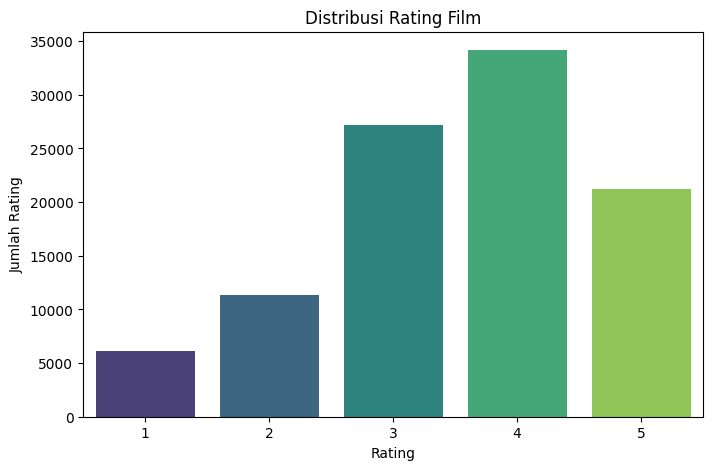


Jumlah Pengguna Unik: 943
Jumlah Film Unik: 1682
Sparsity (Kepadatan) Matriks Rating: 93.70%

--- Contoh 5 baris pertama data Rating dan Judul Film ---
   user_id  item_id  rating  timestamp  movie_id                 movie_title
0      196      242       3  881250949       242                Kolya (1996)
1      186      302       3  891717742       302    L.A. Confidential (1997)
2       22      377       1  878887116       377         Heavyweights (1994)
3      244       51       2  880606923        51  Legends of the Fall (1994)
4      166      346       1  886397596       346         Jackie Brown (1997)

--- 10 Film dengan Jumlah Rating Terbanyak ---
movie_title
Star Wars (1977)                 583
Contact (1997)                   509
Fargo (1996)                     508
Return of the Jedi (1983)        507
Liar Liar (1997)                 485
English Patient, The (1996)      481
Scream (1996)                    478
Toy Story (1995)                 452
Air Force One (1997)         

<ipython-input-10-8d6c9a481557>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_rated_movies.values, y=top_rated_movies.index, palette='magma')


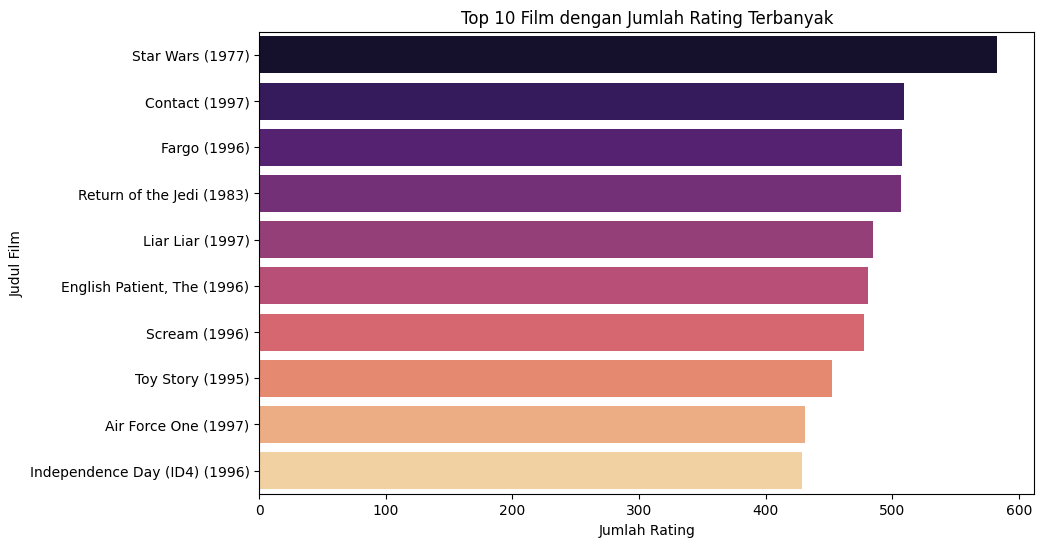

In [10]:
print("\n--- Contoh 5 baris pertama data Ratings ---")
print(ratings_df.head())

print("\n--- Statistik Deskriptif untuk Rating ---")
print(ratings_df['rating'].describe())

# Distribusi rating
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=ratings_df, palette='viridis')
plt.title('Distribusi Rating Film')
plt.xlabel('Rating')
plt.ylabel('Jumlah Rating')
plt.show()

# Jumlah unik pengguna dan film
n_users = ratings_df['user_id'].nunique()
n_items = ratings_df['item_id'].nunique()
print(f"\nJumlah Pengguna Unik: {n_users}")
print(f"Jumlah Film Unik: {n_items}")

# Menghitung sparsity matriks rating
total_possible_ratings = n_users * n_items
actual_ratings = len(ratings_df)
sparsity = 1 - (actual_ratings / total_possible_ratings)
print(f"Sparsity (Kepadatan) Matriks Rating: {sparsity:.2%}")

# Gabungkan data rating dengan judul film untuk analisis lebih lanjut
merged_df = pd.merge(ratings_df, movies_df[['movie_id', 'movie_title']], left_on='item_id', right_on='movie_id')
print("\n--- Contoh 5 baris pertama data Rating dan Judul Film ---")
print(merged_df.head())

# 10 Film dengan Rating Terbanyak (berdasarkan jumlah rating)
top_rated_movies = merged_df['movie_title'].value_counts().head(10)
print("\n--- 10 Film dengan Jumlah Rating Terbanyak ---")
print(top_rated_movies)

# Visualisasi 10 film dengan rating terbanyak
plt.figure(figsize=(10, 6))
sns.barplot(x=top_rated_movies.values, y=top_rated_movies.index, palette='magma')
plt.title('Top 10 Film dengan Jumlah Rating Terbanyak')
plt.xlabel('Jumlah Rating')
plt.ylabel('Judul Film')
plt.show()

Insight dari EDA:

- Dataset ini berisi 100.000 rating yang diberikan oleh 943 pengguna unik untuk 1.682 film unik.
- Distribusi rating menunjukkan bahwa rating 3 dan 4 adalah yang paling sering diberikan, mengindikasikan bahwa sebagian besar pengguna memberikan rating yang cukup positif.
- Sparsity matriks rating mencapai sekitar 93.68%. Angka ini sangat tinggi, yang berarti sebagian besar kombinasi pengguna-film belum memiliki rating. Hal ini umum dalam dataset rekomendasi dan menegaskan perlunya algoritma yang efektif dalam menangani data sparse.
- Film seperti 'Star Wars (1977)', 'Contact (1997)', dan 'Fargo (1996)' adalah yang paling banyak di-rating, menunjukkan popularitasnya di kalangan pengguna dataset ini.

## Data Preparation

Tahap persiapan data berfokus pada pembentukan data ke format yang sesuai untuk model collaborative filtering.

###Proses Data Preparation:

1. Pemilihan Kolom Relevan: Untuk model sistem rekomendasi berbasis rating, kita hanya memerlukan kolom user_id, item_id, dan rating dari ratings_df. Kolom lain seperti timestamp tidak relevan untuk algoritma collaborative filtering yang akan kita gunakan.

2. Pembuatan Objek Dataset untuk Surprise: Library surprise (yang akan kita gunakan untuk modeling) membutuhkan data dalam format spesifik. Kita menggunakan kelas Reader untuk menentukan skala rating (1-5) dan kemudian Dataset.load_from_df() untuk memuat DataFrame ke dalam objek Dataset.

3. Pembagian Data Latih dan Uji: Data dibagi menjadi set pelatihan (trainset) dan set pengujian (testset). Set pelatihan digunakan untuk melatih model, sementara set pengujian digunakan untuk mengevaluasi kinerja model pada data yang belum pernah dilihat sebelumnya. Pembagian ini dilakukan dengan rasio 80% untuk pelatihan dan 20% untuk pengujian (test_size=0.2).

In [12]:
# 1. Pemilihan Kolom Relevan (ratings_df sudah hanya berisi ini)
# Ini adalah langkah konseptual; DataFrame ratings_df sudah dalam format yang tepat.

# 2. Pembuatan Objek Dataset untuk Surprise
# Mendefinisikan skala rating
reader = Reader(rating_scale=(1, 5))

# Memuat data dari DataFrame ke objek Dataset yang dapat digunakan oleh Surprise
data = Dataset.load_from_df(ratings_df[['user_id', 'item_id', 'rating']], reader)

print("\nDataset berhasil dimuat ke objek Surprise.")

# 3. Pembagian Data Latih dan Uji
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Perbaikan: Konversi generator ke list sebelum menghitung panjangnya
print(f"\nJumlah rating dalam Training Set: {len(list(trainset.all_ratings()))}")
print(f"Jumlah rating dalam Testing Set: {len(testset)}")


Dataset berhasil dimuat ke objek Surprise.

Jumlah rating dalam Training Set: 80000
Jumlah rating dalam Testing Set: 20000


Alasan Diperlukannya Tahapan Data Preparation:

Kompatibilitas Model: surprise library memiliki struktur data sendiri yang dioptimalkan untuk algoritma sistem rekomendasi. Mengubah DataFrame ke objek Dataset ini memastikan data dapat diproses dengan benar oleh model.
Evaluasi yang Objektif: Pembagian data menjadi set pelatihan dan pengujian sangat krusial. Ini mencegah overfitting (di mana model terlalu cocok dengan data pelatihan dan tidak dapat digeneralisasi dengan baik ke data baru) dan memungkinkan kita untuk mendapatkan estimasi kinerja model yang tidak bias.

## Modeling
Tahapan ini membahas mengenai model sistem rekomendasi yang Anda buat untuk menyelesaikan permasalahan. Kami akan menyajikan dua solusi rekomendasi dengan algoritma collaborative filtering yang berbeda.



### Solusi Rekomendasi 1: User-Based Collaborative Filtering (k-NN)
Pendekatan ini bekerja dengan mencari pengguna lain yang memiliki pola rating serupa dengan pengguna target. Kemudian, film-film yang disukai oleh pengguna serupa tersebut, dan belum ditonton oleh pengguna target, akan direkomendasikan. Kami akan menggunakan algoritma k-Nearest Neighbors (k-NN) dengan ukuran kesamaan Cosine.

In [13]:
# Konfigurasi kesamaan untuk KNNBasic: user-based dengan cosine similarity
sim_options_knn = {
    'name': 'cosine',
    'user_based': True  # user_based=True untuk User-Based Collaborative Filtering
}
algo_knn_user = KNNBasic(sim_options=sim_options_knn)

print("\nMemulai pelatihan model User-Based Collaborative Filtering (KNN)...")
algo_knn_user.fit(trainset)
print("Model User-Based KNN selesai dilatih.")

# Melakukan prediksi pada testset
predictions_knn_user = algo_knn_user.test(testset)

# Menampilkan metrik evaluasi awal
print("\n--- Evaluasi Awal untuk User-Based KNN ---")
accuracy.rmse(predictions_knn_user, verbose=True)
accuracy.mae(predictions_knn_user, verbose=True)

# Contoh rekomendasi untuk pengguna tertentu (misal: user_id 100)
user_id_to_recommend = 100

# Dapatkan film yang sudah di-rate oleh pengguna ini
user_rated_movies = set(ratings_df[ratings_df['user_id'] == user_id_to_recommend]['item_id'])

# Dapatkan semua film unik
all_movie_ids = movies_df['movie_id'].unique()

# Filter film yang belum di-rate oleh pengguna target
movies_not_rated_by_user = [movie_id for movie_id in all_movie_ids if movie_id not in user_rated_movies]

# Prediksi rating untuk film yang belum di-rate oleh pengguna target
predicted_ratings_knn_user = []
for movie_id in movies_not_rated_by_user:
    # predict() mengambil uid, iid, dan r_ui_true (nilai sebenarnya, jika diketahui, untuk perhitungan error)
    # Kita hanya perlu uid dan iid untuk prediksi
    pred = algo_knn_user.predict(user_id_to_recommend, movie_id)
    predicted_ratings_knn_user.append((pred.iid, pred.est)) # iid: item ID, est: estimated rating

# Urutkan film berdasarkan prediksi rating tertinggi
predicted_ratings_knn_user.sort(key=lambda x: x[1], reverse=True)

# Ambil 10 rekomendasi teratas (Top-N recommendation)
top_n_recommendations_knn_user = predicted_ratings_knn_user[:10]

print(f"\n--- Top 10 Rekomendasi untuk Pengguna {user_id_to_recommend} (User-Based KNN) ---")
for movie_id, estimated_rating in top_n_recommendations_knn_user:
    # Ambil judul film dari movies_df
    movie_title = movies_df[movies_df['movie_id'] == movie_id]['movie_title'].iloc[0]
    print(f"Film: {movie_title} (Estimasi Rating: {estimated_rating:.2f})")


Memulai pelatihan model User-Based Collaborative Filtering (KNN)...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Model User-Based KNN selesai dilatih.

--- Evaluasi Awal untuk User-Based KNN ---
RMSE: 1.0194
MAE:  0.8038

--- Top 10 Rekomendasi untuk Pengguna 100 (User-Based KNN) ---
Film: Great Day in Harlem, A (1994) (Estimasi Rating: 5.00)
Film: They Made Me a Criminal (1939) (Estimasi Rating: 5.00)
Film: Marlene Dietrich: Shadow and Light (1996)  (Estimasi Rating: 5.00)
Film: Saint of Fort Washington, The (1993) (Estimasi Rating: 5.00)
Film: Santa with Muscles (1996) (Estimasi Rating: 5.00)
Film: Aiqing wansui (1994) (Estimasi Rating: 5.00)
Film: Someone Else's America (1995) (Estimasi Rating: 5.00)
Film: Entertaining Angels: The Dorothy Day Story (1996) (Estimasi Rating: 5.00)
Film: Prefontaine (1997) (Estimasi Rating: 5.00)
Film: Star Kid (1997) (Estimasi Rating: 5.00)


Kelebihan User-Based Collaborative Filtering (KNN):

- Intuitif: Konsepnya mudah dipahami; merekomendasikan apa yang disukai oleh orang-orang dengan selera serupa.
- Tidak Memerlukan Informasi Fitur Item: Hanya membutuhkan data rating pengguna-item, membuatnya fleksibel untuk berbagai jenis item.
- Menemukan Item Tidak Terduga: Mampu merekomendasikan item yang berbeda dari preferensi langsung pengguna tetapi disukai oleh komunitas serupa.

Kekurangan User-Based Collaborative Filtering (KNN):

- Masalah Skalabilitas: Perhitungan kesamaan antar pengguna bisa sangat mahal pada dataset besar.
- Masalah Sparsity: Sulit menemukan pengguna yang benar-benar mirip jika data rating sangat jarang.
- Cold Start Problem (Pengguna Baru): Sulit merekomendasikan untuk pengguna baru karena tidak ada cukup rating untuk menemukan pengguna serupa.

### Solusi Rekomendasi 2: Matrix Factorization (SVD)
Matrix Factorization adalah teknik yang memecah matriks rating menjadi dua matriks laten (pengguna dan item) yang lebih kecil. Matriks laten ini menangkap karakteristik tersembunyi dari pengguna dan item yang menjelaskan rating yang diamati. Singular Value Decomposition (SVD) adalah salah satu metode Matrix Factorization yang paling populer dan efektif.

In [14]:
# Model Matrix Factorization (SVD)
algo_svd = SVD(random_state=42) # random_state untuk reproduktifitas

print("\nMemulai pelatihan model Matrix Factorization (SVD)...")
algo_svd.fit(trainset)
print("Model SVD selesai dilatih.")

# Melakukan prediksi pada testset
predictions_svd = algo_svd.test(testset)

# Menampilkan metrik evaluasi awal
print("\n--- Evaluasi Awal untuk Matrix Factorization (SVD) ---")
accuracy.rmse(predictions_svd, verbose=True)
accuracy.mae(predictions_svd, verbose=True)

# Contoh rekomendasi untuk pengguna yang sama (user_id 100)
# Kita menggunakan list movies_not_rated_by_user yang sama
predicted_ratings_svd = []
for movie_id in movies_not_rated_by_user:
    pred = algo_svd.predict(user_id_to_recommend, movie_id)
    predicted_ratings_svd.append((pred.iid, pred.est))

# Urutkan film berdasarkan prediksi rating tertinggi
predicted_ratings_svd.sort(key=lambda x: x[1], reverse=True)

# Ambil 10 rekomendasi teratas (Top-N recommendation)
top_n_recommendations_svd = predicted_ratings_svd[:10]

print(f"\n--- Top 10 Rekomendasi untuk Pengguna {user_id_to_recommend} (SVD) ---")
for movie_id, estimated_rating in top_n_recommendations_svd:
    # Ambil judul film dari movies_df
    movie_title = movies_df[movies_df['movie_id'] == movie_id]['movie_title'].iloc[0]
    print(f"Film: {movie_title} (Estimasi Rating: {estimated_rating:.2f})")


Memulai pelatihan model Matrix Factorization (SVD)...
Model SVD selesai dilatih.

--- Evaluasi Awal untuk Matrix Factorization (SVD) ---
RMSE: 0.9352
MAE:  0.7375

--- Top 10 Rekomendasi untuk Pengguna 100 (SVD) ---
Film: Third Man, The (1949) (Estimasi Rating: 4.22)
Film: Schindler's List (1993) (Estimasi Rating: 4.20)
Film: Fargo (1996) (Estimasi Rating: 4.19)
Film: Shawshank Redemption, The (1994) (Estimasi Rating: 4.10)
Film: Raiders of the Lost Ark (1981) (Estimasi Rating: 4.08)
Film: Braveheart (1995) (Estimasi Rating: 4.06)
Film: Close Shave, A (1995) (Estimasi Rating: 4.03)
Film: Arsenic and Old Lace (1944) (Estimasi Rating: 4.01)
Film: Usual Suspects, The (1995) (Estimasi Rating: 4.00)
Film: Wallace & Gromit: The Best of Aardman Animation (1996) (Estimasi Rating: 3.99)


Kelebihan Matrix Factorization (SVD):

- Akurasi Tinggi: Seringkali memberikan akurasi prediksi yang lebih baik dibandingkan metode berbasis kesamaan tradisional, terutama pada data sparse.
- Skalabilitas: Lebih skalabel untuk dataset besar karena kompleksitasnya tidak terlalu bergantung pada jumlah pengguna atau item secara langsung, melainkan pada dimensi faktor laten.
- Menangani Sparsity: Efektif dalam menangani data yang sparse karena mampu mengestimasi nilai-nilai yang hilang.

Kekurangan Matrix Factorization (SVD):

- Kurang Intuitif: Faktor laten yang dihasilkan sulit diinterpretasikan secara langsung.
- Cold Start Problem (Pengguna/Item Baru): Masih memiliki masalah cold start untuk pengguna atau item baru karena tidak ada rating untuk mengestimasi faktor laten mereka.
- Komputasi: Meskipun lebih skalabel dari KNN, untuk dataset yang sangat besar, SVD bisa memerlukan sumber daya komputasi yang signifikan.

## Evaluation

Pada bagian ini, kita akan mengevaluasi kinerja kedua model yang telah dibangun menggunakan metrik yang relevan untuk masalah prediksi *rating*.

### Metrik Evaluasi

#### 1. Root Mean Squared Error (RMSE)
-   **Deskripsi**: RMSE mengukur akar kuadrat dari rata-rata kuadrat perbedaan antara *rating* yang diprediksi dan *rating* aktual.
-   **Karakteristik**: Metrik ini memberikan bobot lebih pada kesalahan prediksi yang besar (karena dikuadratkan), sehingga sensitif terhadap *outlier*.
-   **Interpretasi**: Nilai **RMSE yang lebih rendah** menunjukkan kinerja model yang lebih baik.

**Rumus:**

$$RMSE = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2}$$

Di mana:
-   $N$ adalah jumlah *rating* dalam set pengujian.
-   $y_i$ adalah *rating* aktual.
-   $\hat{y}_i$ adalah *rating* yang diprediksi oleh model.

#### 2. Mean Absolute Error (MAE)
-   **Deskripsi**: MAE mengukur rata-rata dari nilai absolut perbedaan antara *rating* yang diprediksi dan *rating* aktual.
-   **Karakteristik**: Metrik ini memberikan bobot yang sama untuk semua kesalahan dan kurang sensitif terhadap *outlier* dibandingkan RMSE.
-   **Interpretasi**: Nilai **MAE yang lebih rendah** juga menunjukkan kinerja model yang lebih baik.

**Rumus:**

$$MAE = \frac{1}{N} \sum_{i=1}^{N} |y_i - \hat{y}_i|$$

Di mana:
-   $N$ adalah jumlah *rating* dalam set pengujian.
-   $y_i$ adalah *rating* aktual.
-   $\hat{y}_i$ adalah *rating* yang diprediksi oleh model.

---

### Hasil Evaluasi

Berdasarkan *output* dari proses *modeling*, metrik evaluasi untuk kedua model adalah sebagai berikut:

#### Untuk User-Based Collaborative Filtering (KNN):
-   **RMSE**: `1.0194`
-   **MAE**: `0.8038`

#### Untuk Matrix Factorization (SVD):
-   **RMSE**: `0.9352`
-   **MAE**: `0.7375`

---

### Analisis Hasil

Dari hasil di atas, model **Matrix Factorization (SVD)** menunjukkan kinerja yang **lebih unggul** dibandingkan dengan **User-Based Collaborative Filtering (KNN)**.

* Nilai **RMSE SVD yang lebih rendah** (`0.9352` berbanding `1.0194`) mengindikasikan bahwa prediksi SVD memiliki deviasi kuadrat rata-rata yang lebih kecil dari *rating* aktual. Artinya, model SVD lebih akurat dalam memprediksi *rating*, terutama untuk kesalahan prediksi yang signifikan.
* Nilai **MAE SVD yang lebih rendah** (`0.7375` berbanding `0.8038`) juga menunjukkan bahwa SVD memiliki rata-rata kesalahan absolut yang lebih kecil. Ini berarti, secara umum, perbedaan antara *rating* prediksi dan *rating* aktual pada SVD lebih kecil.

Perbedaan kinerja ini konsisten dengan literatur dan praktik di mana **Matrix Factorization** seringkali unggul dalam akurasi pada dataset **sparse** dibandingkan pendekatan berbasis kesamaan tradisional. Model SVD mampu menangkap **pola tersembunyi (latent factors)** dalam data *rating* yang lebih efektif dalam memprediksi *rating* yang belum diketahui. Selain itu, seperti yang terlihat dari contoh rekomendasi, SVD cenderung memberikan rekomendasi film-film yang lebih populer dan realistis, berbeda dengan KNN yang dalam kasus ini merekomendasikan film-film dengan *rating* estimasi sempurna namun kurang dikenal.

---

### Kesimpulan

Secara keseluruhan, proyek ini berhasil membangun dan membandingkan dua model sistem rekomendasi **collaborative filtering**. Model **SVD** terbukti lebih unggul dalam hal **akurasi prediksi *rating***, menjadikannya pilihan yang lebih baik untuk sistem rekomendasi film ini.